# Finding the most likely value of CADR using Brute Force

Below I develop a brute-force method to find the clean air delivery rate (CADR) using data.

Pros:
- fast
- easy to implement
- less complicated than Bayesian inference

Cons:
- don't get the benefits of Bayesian inference 
    - no credible intervals
    - can't specify our prior beliefs about parameters. Sometimes we have incomplete information. By using Bayesian inference, we could specify prior distributions so that modeling can take into account domain expertise, measurement error, etc.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

The source of the equations below is [Quantitative Assessment of Natural Ventilation in an
Elementary School Classroom in the Context of COVID-19 and
Its Impact in Airborne Transmission](https://www.mdpi.com/2076-3417/12/18/9261/pdf) by Vignolo et. al.

## Mass-Balance Equation

$$
\begin{equation}
\begin{aligned}
\frac{dC(t)}{dt} = \frac{n \cdot G \cdot 1000000 + Q \cdot ( C_{ext} - C(t))}{V}
\end{aligned}
\end{equation}
$$




In [4]:
def derivative_of_c_of_t(c_t, c_ext=420, n=16, G=0.00735, Q=500, V=8000):
    ppm_1 = 1_000_000
    return (n * G * ppm_1 + Q * (c_ext - c_t)) / V

## After integration

$$
\begin{equation}
\begin{aligned}
C(t) &= C_{ext} + \frac{n \cdot G \cdot 1000000 }{Q} - (C_{ext} - C_0 + \frac{n \cdot G \cdot 1000000 }{Q}) \cdot e^{-Q/V \cdot t}
\end{aligned}
\end{equation}
$$

In [5]:
def concentration_at_t(t, c_0=420, c_ext=420, n=16, G=0.00735, Q=500, V=8000):
    ppm_1 = 1_000_000
    return c_ext + n * G * ppm_1 / Q - (c_ext - c_0 + n * G * ppm_1 / Q) * np.exp(-Q / V * t)
    

In [6]:
collection = [420]
for i in range(120):
    collection.append(collection[-1] + derivative_of_c_of_t(collection[-1]))

We can see that the mass balance equation can be applied recursively to get the CO2 curve. I.e. To get $C(t+1)$, add the $\frac{dC(t)}{dt}$ term to $C(t)$.
We could also get the CO2 curve a different way -- by using the integral of the mass balance equation and plugging in $0,1,...T$ for $C(t)$.

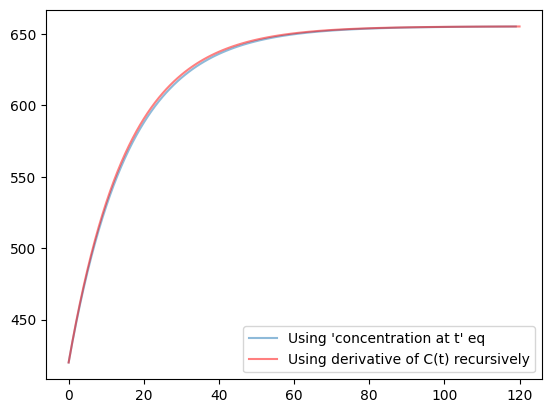

In [7]:
fig, ax = plt.subplots(1,1)

pd.Series(concentration_at_t(np.arange(0,120, 1))).plot(ax=ax, alpha=0.5)
pd.Series(collection).plot(ax=ax, color='r', alpha=0.5)
ax.legend(["Using 'concentration at t' eq", "Using derivative of C(t) recursively"])

In [8]:
fake_data = pd.Series(concentration_at_t(np.arange(0,120, 1), c_0=1000))

## find_cadr

In [9]:
pd.Series([1,2,3]) - pd.Series([1,1,1])

0    0
1    1
2    2
dtype: int64

In [10]:
abs(pd.Series([0,2,3]) - pd.Series([1,1,1]))

0    1
1    1
2    2
dtype: int64

In [11]:
abs(pd.Series([0,2,3]) - pd.Series([1,1,1])).sum()

4

In [12]:
fake_data

0      1000.000000
1       979.109624
2       959.484932
3       941.049240
4       923.730510
          ...     
115     655.460661
116     655.444868
117     655.430032
118     655.416095
119     655.403003
Length: 120, dtype: float64

In [13]:
def find_cadr(producer, data, producer_args):
    """
    Find the best fitting CADR value (in cfm).
    
    Currently doing brute force:
    
    For each possible CADR value, evaluate the error.
    The "best" is the one that produces the lowest error.
    """
    minimum = 0
    min_diff = np.inf
    
    for i in range(1, 10000):
        producer_args['Q'] = i / 10
        new_data = producer(**producer_args)
        diff = abs((data- new_data)).sum()
        
        if diff < min_diff:
            minimum = i
            min_diff = diff
            
    return { 'best_guess': minimum / 10, 'min_diff': min_diff }

In [14]:
find_cadr(concentration_at_t, fake_data, producer_args={'c_0': 1000, 't': np.arange(120)})

{'best_guess': 500.0, 'min_diff': 0.0}

<AxesSubplot: >

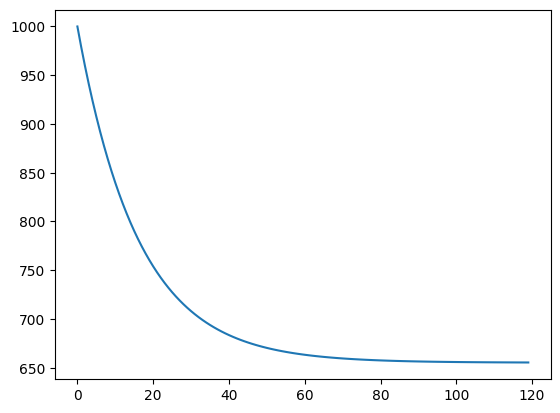

In [15]:
fake_data.plot()

## find_best

In [16]:
def find_best(producer, data, producer_args):
    min_error = np.inf
    min_error_2 = np.inf
    min_args = {'c_0': producer_args['c_0'], 'Q': producer_args['Q']}
    #import pdb; pdb.set_trace()
    iterations = 0
    for i in range(1000):
        
        min_error_2 = min_error

        old_val_c_0 = producer_args['c_0']
        old_val_Q = producer_args['Q']
        
        for c_0 in [-0.1, 0, 0.1]:
            
            #import pdb; pdb.set_trace()

            
            for Q in [-0.1, 0, 0.1]:
                
                new_val_c_0 = old_val_c_0 + c_0
                new_val_Q = old_val_Q + Q
                
                if new_val_c_0 < 0 or new_val_Q <= 0:
                    continue
                    
                producer_args['c_0'] = new_val_c_0
                producer_args['Q'] = new_val_Q

                new_data = producer(**producer_args)
                error = abs(data - new_data).sum()
                
                if error < min_error:
                    min_args = dict(producer_args)
                    min_error = error
        #import pdb; pdb.set_trace()
        if min_error == min_error_2 and min_error_2 != np.inf:
            return min_args, i, min_error
        iterations += 1
        
    return min_args, iterations, min_error

In [17]:
fake_data

0      1000.000000
1       979.109624
2       959.484932
3       941.049240
4       923.730510
          ...     
115     655.460661
116     655.444868
117     655.430032
118     655.416095
119     655.403003
Length: 120, dtype: float64

In [18]:
find_best(
    concentration_at_t, fake_data, producer_args={'c_0': fake_data[0:3].mean(), 't': np.arange(120), 'Q': 500},
)

({'c_0': 979.6315186897516,
  't': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119]),
  'Q': 499.9},
 1,
 331.09018061065126)

In [19]:
find_best(
    concentration_at_t, fake_data, producer_args={'c_0': fake_data[0:3].mean(), 't': np.arange(120), 'Q': 50},
)

({'c_0': 1079.3315186897114,
  't': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119]),
  'Q': 149.9999999999953},
 1000,
 54164.025625883485)

## gradient_descent

In [61]:
def gradient_descent(producer, data, producer_args, grad_args):
    
    point_1 = (
        producer_args['c_0'],
        producer_args['Q']
    )
    
    new_data = producer(**producer_args)
    # What is the error at the current spot?
    error_1 = abs((data- new_data)).sum()

    point_2 = (point_1[0] + np.random.uniform(-0.1, 0.1), point_1[1] + np.random.uniform(-0.1, .1))
    #producer_args['c_0'] = point_2[0]
    producer_args['Q'] = point_2[1]
    new_data = producer(**producer_args)
    # What is the error at the new spot?
    error_2 = abs((data- new_data)).sum()
    
    #change_c_0 = point_2[0] - point_1[0]
    change_Q = point_2[1] - point_1[1]
    change_error = error_2 - error_1
    
    for i in range(10000):
        old = (producer_args['c_0'], producer_args['Q'])
        
        # Update parameters
        #producer_args['c_0'] = -grad_args['step_size'] * change_error / change_c_0 + old[0]
        producer_args['Q'] = -grad_args['step_size'] * change_error / change_Q + old[1]

        # Produce new stuff
        new_data = producer(**producer_args)


        error_1 = error_2
        error_2 = abs((data- new_data)).sum()
        
        # The new stuff becomes the old
        #data = new_data
        
        # Compute difference in error
        change_error = error_2 - error_1

        #change_c_0 = producer_args['c_0'] - old[0]
        change_Q = producer_args['Q'] - old[1]        

        #if change_c_0 < 0.1 and change_Q < 0.1:
        if change_Q < 0.001 and change_Q > -.001:
             return producer_args, error_2
        
    return producer_args, error_2

In [25]:
prod_args_mean, error_3, c_error_3 = gradient_descent(
    concentration_at_t, fake_data, producer_args={'c_0': fake_data[0:3].mean(), 't': np.arange(120), 'Q': 1},
    grad_args={'step_size': 0.0005}
)

<AxesSubplot: >

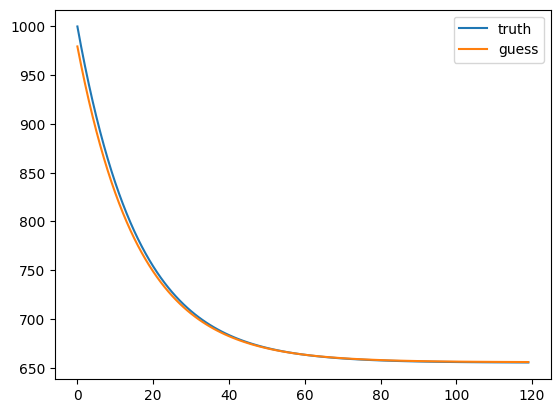

In [27]:
pd.DataFrame({
    'truth': fake_data,
    'guess': pd.Series(concentration_at_t(Q=prod_args_mean['Q'], c_0=prod_args_mean['c_0'], t=np.arange(120)))
}).plot()

In [31]:
prod_args_mean, error_3, c_error_3 = gradient_descent(
    concentration_at_t, fake_data, producer_args={'c_0': fake_data[0:3].mean(), 't': np.arange(120), 'Q': 1000},
    grad_args={'step_size': 0.005}
)

In [32]:
prod_args_mean

{'c_0': 979.5315186897516,
 't': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119]),
 'Q': 499.0154832873141}

<AxesSubplot: >

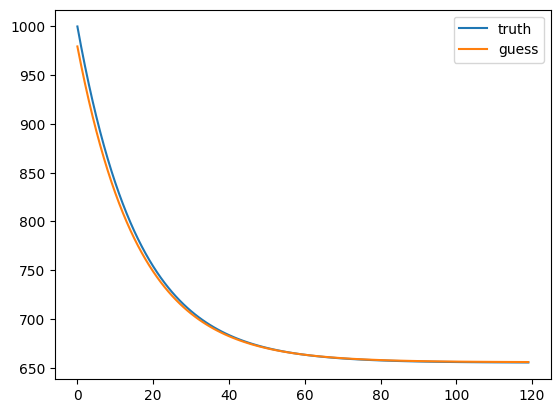

In [33]:
pd.DataFrame({
    'truth': fake_data,
    'guess': pd.Series(concentration_at_t(Q=prod_args_mean['Q'], c_0=prod_args_mean['c_0'], t=np.arange(120)))
}).plot()

## Load up some real data

I'm using the CO2 data from when I, my wife, and dog were sleeping. See [Table 4 of Carbon dioxide generation rates for building occupants](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5666301/). For someone sleeping in the 30-40 age group & male, CO2 generation rate is 0.0037 L/s or 0.0078 cfm. For women in that age group, the mean CO2 generation rate is 0.0029 L/s or 0.0061 $ft^3/min$. My 4-year-old dog of course also outputs CO2. I'm using Age 3 to 6, male data for my dog, which is 0.0019 L/s or 0.004 cfm. Taking the average of the three is 0.0053. We can plug this value into $G$ in the function below.

In [34]:
df = pd.read_csv("../co2-data/Aranet4 0FCCA_2022-11-08T07_01_26-0500.csv")

In [35]:
df['Time'] = pd.to_datetime(df['Time(mm/dd/yyyy)'])

In [36]:
df['Carbon dioxide(ppm)']

0        1367
1        1390
2        1397
3        1369
4        1380
         ... 
16536     901
16537     916
16538     904
16539     916
16540     917
Name: Carbon dioxide(ppm), Length: 16541, dtype: int64

In [37]:
study = df[(df['Time'] >= '2022-11-07 21:44:00') & (df['Time'] <= '2022-11-08 02:42:00')]

Looks like the readings are starting to reach steady state at the end.

<AxesSubplot: xlabel='Time'>

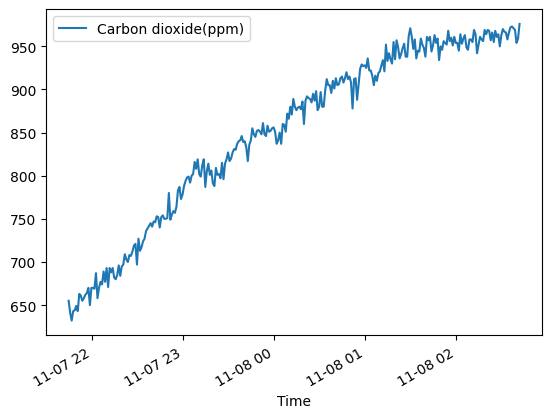

In [38]:
study[['Time', 'Carbon dioxide(ppm)']].plot(x='Time', y='Carbon dioxide(ppm)')

In [39]:
study.iloc[0:3]

,Time(mm/dd/yyyy),Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),Time
15984,11/07/2022 9:44:45 PM,655,70.5,31,1021,2022-11-07 21:44:45
15985,11/07/2022 9:45:45 PM,641,70.5,31,1021,2022-11-07 21:45:45
15986,11/07/2022 9:46:45 PM,632,70.6,31,1021,2022-11-07 21:46:45


In [40]:
pred_args_real, error_real, _ = gradient_descent(
    concentration_at_t, 
    study['Carbon dioxide(ppm)'], 
    producer_args={'c_0': study.iloc[0:2]['Carbon dioxide(ppm)'].mean(), 't': np.arange(study.shape[0]), 'Q': 0.1},
    grad_args={'step_size': 0.005}
)

In [41]:
study.reset_index()['Carbon dioxide(ppm)']

0      655
1      641
2      632
3      643
4      644
      ... 
293    971
294    969
295    954
296    959
297    976
Name: Carbon dioxide(ppm), Length: 298, dtype: int64

### blah

In [42]:
pred_best, _, min_error = find_best(
    concentration_at_t, 
    study.reset_index()['Carbon dioxide(ppm)'], 
    producer_args={'c_0': study.reset_index().iloc[0:2]['Carbon dioxide(ppm)'].mean(), 't': np.arange(study.shape[0]), 'Q': 0.1}
)

In [62]:
pred_gd, error = gradient_descent(
    concentration_at_t, 
    study.reset_index()['Carbon dioxide(ppm)'], 
    producer_args={
        'c_0': study.reset_index().iloc[0:2]['Carbon dioxide(ppm)'].mean(), 
        't': np.arange(study.shape[0]), 
        'Q': 0.1,
        'n': 3, 
        'G': 0.0053, 
        'V': 10 * 13 * 8 * 5 * 0.8, 
    },
    
    grad_args={'step_size': 0.0005}
    
)

In [63]:
gd_error

3467.119116630804

In [64]:
pred_gd

{'c_0': 648.0,
 't': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173

In [67]:
args = {'n': 3, 'G': 0.0053, 'V': 10 * 13 * 8 * 5 * 0.8, 'c_0': pred_gd['c_0'], 't': np.arange(study.shape[0] * 10), 'Q': pred_gd['Q']}
prediction = concentration_at_t(**args)

<AxesSubplot: xlabel='Time'>

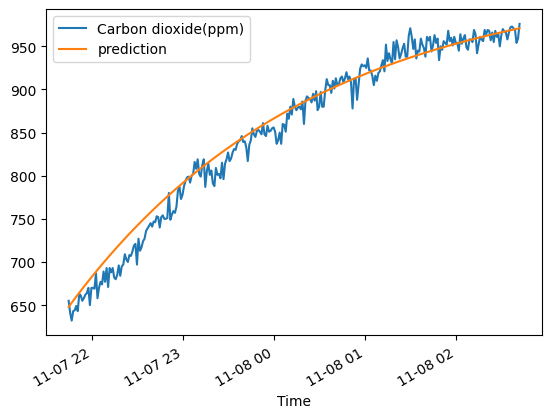

In [68]:
fig, ax = plt.subplots()
study[['Time', 'Carbon dioxide(ppm)']].plot(x='Time', y='Carbon dioxide(ppm)', ax=ax)
new_df = pd.DataFrame({'prediction': prediction})

reset = study.reset_index()
new_df['Time'] = reset['Time']

new_df.plot(ax=ax, x='Time', y='prediction')

## Steady state

Steady state is predicted to be 1033.

In [256]:
pd.Series(concentration_at_t(**args)).tail()

2975    1033.89961
2976    1033.89961
2977    1033.89961
2978    1033.89961
2979    1033.89961
dtype: float64

<AxesSubplot: >

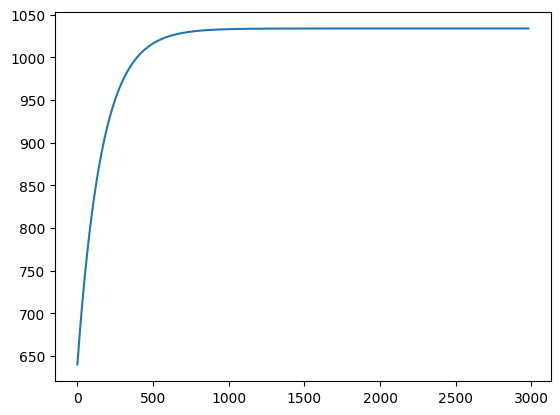

In [247]:
pd.Series(concentration_at_t(**args)).plot()

The volume of the house occupied by air is 5792 $ft^3$.

In [251]:
905 * 8 * 0.8

5792.0

The prediction above says we're getting about 25.9 $ft^3/min$. We can get ACH by multiplying that by 60 (to get to the rate for an hour), then divide by the volume occupied by air.

In [252]:
25.9 * 60 / 5792

0.2683011049723757

So we're getting about 0.27 ACH.

Using the [NIST CO2 tool](https://pages.nist.gov/CONTAM-apps/webapps/CO2Tool/#/), plugging in 0.27 ACH, volume, they estimate the steady state to be around 979 ppm, which is about 50ppm from the estimate above. See the report generated in `co2-data/Edderic's house_Results.txt` for details.

# Conclusion

The brute-force method can produce good fit, assuming constant occupancy & behavior during the study period. We can validly estimate CADR. Using the NIST CO2 tool mentioned above as reference, we see that the steady state generated using brute force is quite close to one that is generated, which adds to the validity of this approach.